# LANL Host Dataset

### Article : https://www.worldscientific.com/doi/pdf/10.1142/9781786345646_001

Notes:

"The events from the host logs included in the data set are all related to authentication and process activity on each machine"

### Pour obtenir le dataset:
1- https://csr.lanl.gov/data/2017/#citing : donner mail, obtenir le lien

2- https://csr.lanl.gov/data-fence/... 10 chiffres.../... token... iXYXXbqw15UugRnZALCZ2Y8dvEk=... /unified-host-network-dataset-2017/wls.html pour avoir l'index avec tous les fichiers compressés

3- download : for i in $(seq -w 1 90); do wget -c https://csr.lanl.gov/data-fence/...10 chiffres.../...token.../unified-host-network-dataset-2017/wls/wls_day-$i.bz2; done

4- decompress, as required : bzip2 -dk filename.bz2

### EventID : 

EventID         Description

Authentication events

4768            Kerberos authentication ticket was requested (TGT)

4769            Kerberos service ticket was requested (TGS)

4770            Kerberos service ticket was renewed

4774            An account was mapped for logon

4776            Domain controller attempted to validate credentials

4624            An account successfully logged on, see Logon Types

4625            An account failed to logon, see Logon Types

4634            An account was logged off, see Logon Types

4647            User initiated logoff

4648            A logon was attempted using explicit credentials

4672            Special privileges assigned to a new logon

4800            The workstation was locked

4801            The workstation was unlocked

4802            The screensaver was invoked

4803            The screensaver was dismissed

Process events

4688            Process start

4689            Process end

System events

4608            Windows is starting up

4609            Windows is shutting down

1100            Event logging service has shut down (often recorded instead of EventID 4609)


Detailed description : - EventID : https://learn.microsoft.com/en-us/windows-server/identity/ad-ds/plan/appendix-l--events-to-monitor


### Logon Types for EventIDs: 4624, 4625 and 4634

LogonTypes (EventIDs: 4624, 4625 and 4634)

2 — Interactive

3 — Network

4 — Batch

12 — Cached Remote-Interactive

5 — Service

9 — New Credentials

7 — Unlock

10 — Remote Interactive

8 — Network Clear Text 11 — Cached Interactive

0 — Used only by the system account

### Host Log Fields

. Time: The epoch time of the event in seconds.

• EventID: Four digit integer corresponding to the event id of the record.

• LogHost: The hostname of the computer that the event was recorded on.In the case of directed authentication events, the LogHost will correspond to the computer that the authentication event is terminating at (destination computer).

• LogonType: Integer corresponding to the type of logon, see Table 2.

• LogonTypeDescription: Description of the LogonType, see Table 2.

• UserName: The user account initiating the event. If the user ends in $, then it corresponds to a computer account for the specified computer.

• DomainName: Domain name of UserName.

• LogonID: A semi-unique (unique between current sessions and LogHost)number that identifies the logon session just initiated. Any events logged subsequently during this logon session should report the same LogonID through to the logoff event.

• SubjectUserName: For authentication mapping events, the user account specified by this field is mapping to the user account in UserName.

• SubjectDomainName: Domain name of SubjectUserName.

• SubjectLogonID: See LogonID.

• Status: Status of the authentication request. “0 × 0” means success otherwise failure; failure codes for the appropriate EventID are available online.f

• Source: For authentication events, this will correspond to the the computer where the authentication originated (source computer), if it is a local logon event then this will be the same as the LogHost.

• ServiceName: The account name of the computer or service the user is requesting the ticket for.

• Destination: This is the server the mapped credential is accessing. This may indicate the local computer when starting another process with new account credentials on a local computer.

• AuthenticationPackage: The type of authentication occurring including Negotiate, Kerberos, NTLM plus a few more.

• FailureReason: The reason for a failed logon.

• ProcessName: The process executable name, for authentication events this is the process that processed the authentication event. ProcessNames may include the file type extensions (i.e., exe).

• ProcessID: A semi-unique (unique between currently running processes AND LogHost) value that identifies the process. ProcessID allows you to correlate other events logged in association with the same process through to the process end.

• ParentProcessName: The process executable that started the new process. ParentProcessNames often do not have file extensions like ProcessName but can be compared by removing file extensions from the name.

• ParentProcessID: Identifies the exact process that started the new process. Look for a preceding event 4688 with a ProcessID that matches this ParentProcessID.

In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# lit le fichier de 12+ Gb ligne par ligne

dirpath = '/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'
filename = 'wls_day-01.json'

filepath = dirpath + filename

In [3]:
# lit fichier ligne à ligne

N_SAMPLES = 10
with open(filepath, 'r') as f:
    for i in range(N_SAMPLES):
        line = f.readline()
        # print(line)
        # print(json.dumps(line, sort_keys=True, indent=4))
        obj_json = json.loads(line)
        print(obj_json)

{'UserName': 'Comp607982$', 'EventID': 4688, 'LogHost': 'Comp607982', 'LogonID': '0x3e7', 'DomainName': 'Domain001', 'ParentProcessName': 'services', 'ParentProcessID': '0x2ac', 'ProcessName': 'svchost.exe', 'Time': 1, 'ProcessID': '0x1418'}
{'UserName': 'Comp991643$', 'EventID': 4688, 'LogHost': 'Comp991643', 'LogonID': '0x3e7', 'DomainName': 'Domain001', 'ParentProcessName': 'services', 'ParentProcessID': '0x334', 'ProcessName': 'rundll32.exe', 'Time': 1, 'ProcessID': '0xc0c'}
{'UserName': 'Comp736087$', 'EventID': 4688, 'LogHost': 'Comp736087', 'LogonID': '0x3e7', 'DomainName': 'Domain001', 'ParentProcessName': 'services', 'ParentProcessID': '0x2e8', 'ProcessName': 'svchost.exe', 'Time': 1, 'ProcessID': '0x2074'}
{'UserName': 'Comp093128$', 'EventID': 4688, 'LogHost': 'Comp093128', 'LogonID': '0x3e7', 'DomainName': 'Domain001', 'ParentProcessName': 'services', 'ParentProcessID': '0x2d4', 'ProcessName': 'vssvc.exe', 'Time': 1, 'ProcessID': '0x2200'}
{'UserName': 'Comp006850$', 'Event

In [4]:
authentication_events = {
    4768 : 'Kerberos authentication ticket was requested (TGT)',
    4769 : 'Kerberos service ticket was requested (TGS)',
    4770 : 'Kerberos service ticket was renewed',
    4774 : 'An account was mapped for logon',
    4776 : 'Domain controller attempted to validate credentials',
    4624 : 'An account successfully logged on, see Logon Types',
    4625 : 'An account failed to logon, see Logon Types',
    4634 : 'An account was logged off, see Logon Types',
    4647 : 'User initiated logoff',
    4648 : 'A logon was attempted using explicit credentials',
    4672 : 'Special privileges assigned to a new logon',
    4800 : 'The workstation was locked',
    4801 : 'The workstation was unlocked',
    4802 : 'The screensaver was invoked',
    4803 : 'The screensaver was dismissed'
}

liste_authentication_events = list(authentication_events.keys())

In [5]:
# combien d'EventIDs correspondant à un évènement d'authentification ?

total = 0
auth = 0

N_SAMPLES = 1000

with open(filepath, 'r') as f:
    for i in range(N_SAMPLES):
        line = f.readline()
        obj_json = json.loads(line)
        if obj_json.get('EventID') in liste_authentication_events:
            auth += 1
        total += 1
        print(f'{total} lignes traitées', end='\r', flush=True)

print()
print(f'{total} evènements, dont {auth} pour authentification ({auth/total*100:.2f}%)')

1000 lignes traitées
1000 evènements, dont 570 pour authentification (57.00%)


In [6]:
# Extrait les évènements d'authentification : host event logs capture with authentication eventIDs
# et écrit des fichiers avec des tailles différentes (N samples d'authentification)

N_AUTHENTIFICATION_SAMPLES = [10, 100, 1000, 10000, 100000, 1000000]

#-- fichier json complet ---
dirpath = '/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'
filename = 'wls_day-01.json'
filepath = dirpath + filename

presents = os.listdir(dirpath)

In [7]:
#-- boucle extraction --
for n_authentication_samples in N_AUTHENTIFICATION_SAMPLES:
    subset_filename = 'wls_day-01_subset_' + f'{n_authentication_samples}' + '.json'  # fichier dans lequel on va écrire les lignes avec EventID d'authentification
    if subset_filename in presents:
        print(f'{subset_filename} déjà présent')
    else:
        print(f'extrait {subset_filename}')
        subset_filepath = dirpath + subset_filename
        ctr = 0  # compteur d'évènements d'authentification
        print("\n" + f"Extrait fichier de {n_authentication_samples} évènements d'auhentification")
        with open(filepath, 'r') as f:
            while ctr < n_authentication_samples:
                    line = f.readline()
                    obj_json = json.loads(line)
                    if obj_json.get('EventID') in liste_authentication_events:
                        ctr += 1
                        print(f'{ctr} évènements extraits', end='\r', flush=True)
                        with open(subset_filepath, 'a') as g:
                            g.write(line)

wls_day-01_subset_10.json déjà présent
wls_day-01_subset_100.json déjà présent
wls_day-01_subset_1000.json déjà présent
wls_day-01_subset_10000.json déjà présent
wls_day-01_subset_100000.json déjà présent
wls_day-01_subset_1000000.json déjà présent


# EDA

In [8]:
def get_df_from_file(n_eda=1000, dirpath='/home/benjamin/Folders_Python/Cyber/data/LALN_processed/'):
    """Utility function to get a wls** file and return a DataFrame

    Args:
        n_eda (int, optional): file index. Defaults to 1000.
    """
    
    filename = 'wls_day-01_subset_' + f'{n_eda}' + '.json'

    subset_filepath = dirpath + filename
    print(f'EDA sur {filename}')
    df = pd.read_json(subset_filepath, lines=True)
    
    return df   

In [50]:
N_EDA = [1000000]  # liste de suffixes pour les fichiers à traiter

for n_eda in N_EDA:
    df = get_df_from_file(n_eda=n_eda)

EDA sur wls_day-01_subset_1000000.json


In [51]:
df

,UserName,EventID,LogHost,LogonID,DomainName,LogonTypeDescription,ProcessName,AuthenticationPackage,Time,LogonType,ProcessID,Source,Destination,SubjectUserName,SubjectLogonID,SubjectDomainName,Status,ServiceName,FailureReason
0,system,4624,Comp828729,0x3e7,nt authority,Service,services.exe,Negotiate,1,5.0,0x29c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,system,4672,Comp828729,0x3e7,nt authority,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,system,4672,Comp423597,0x3e7,nt authority,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,system,4624,Comp050550,0x3e7,nt authority,Service,services.exe,Negotiate,1,5.0,0x2ec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Comp939275$,4624,Comp661433,0x23a8696,Domain001,Network,NaN,Kerberos,1,3.0,NaN,Comp939275,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,User897275,4768,ActiveDirectory,NaN,Domain001,NaN,NaN,NaN,2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0,NaN,NaN
999996,User897275,4768,ActiveDirectory,NaN,Domain001,NaN,NaN,NaN,2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0,NaN,NaN
999997,User897275,4768,ActiveDirectory,NaN,Domain001,NaN,NaN,NaN,2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0,NaN,NaN
999998,User897275,4769,ActiveDirectory,NaN,Domain001,NaN,NaN,NaN,2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0,Comp897367$,NaN


### Recherche des NaN

In [64]:
# display %ages of NaN values

df.isna().sum(axis=0).sort_values(ascending=False)/len(df)*100

# NB : 
# 1- Failure Reason is described only when EventID = 4625 (failed logon)
# 2- Destination : need expert view here
# 3- Subject XX : maps to XX ?
# 4- ServiceName : service name user is requesting access for (=additional info)
# 5- ProcessName : process that originated the authentication event
# 6- ProcessID : semi-unique process ID
# 7- Status : status of the request - correlates with code 4625 ?
# 8- Source : source computer, correlates with LogHost
# 9- Authentication Package : type of authentication
# 10- Logon XXs : type and ID of Logons

FailureReason            99.0510
Destination              97.7840
SubjectDomainName        97.7483
SubjectUserName          97.7483
SubjectLogonID           97.7477
ServiceName              95.6066
ProcessName              94.2167
ProcessID                94.2167
Status                   79.4038
Source                   57.5076
AuthenticationPackage    52.0619
LogonType                34.3097
LogonTypeDescription     34.3097
LogonID                  21.0352
EventID                   0.0000
Time                      0.0000
DomainName                0.0000
LogHost                   0.0000
UserName                  0.0000
dtype: float64

In [65]:
# regarde quelles sont les lignes avec FailureReason != NaN : ce sont les EventIDs = 4625 (logon failed)

# df[df['FailureReason'].isna() == False].describe(include='all').transpose()

In [66]:
df.columns

Index(['UserName', 'EventID', 'LogHost', 'LogonID', 'DomainName',
       'LogonTypeDescription', 'ProcessName', 'AuthenticationPackage', 'Time',
       'LogonType', 'ProcessID', 'Source', 'Destination', 'SubjectUserName',
       'SubjectLogonID', 'SubjectDomainName', 'Status', 'ServiceName',
       'FailureReason'],
      dtype='object')

In [73]:
columns_without_nan = ['UserName', 'EventID', 'LogHost', 'DomainName','Time']

columns_to_drop = [ c for c in df.columns if c not in columns_without_nan ]

### Post Processing

In [11]:
#1 créé un user name unique en aggrégeant le UserName et le DomainName

df['UserNameAndDomainName'] = df['UserName'] + '_' + df['DomainName']

### Nettoyage

In [12]:
# Nettoyage :
# 1- Une simple PCA montre que les LogonIDs expliquent 99% de la variance : on les retire

df.drop(columns=['LogonID'], inplace=True)

### Stats générales

In [13]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UserName,1000000,12309,Comp916004$,108928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EventID,1000000.0,NaN,NaN,NaN,4664.048422,57.619354,4624.0,4624.0,4634.0,4672.0,4803.0
LogHost,1000000,6062,ActiveDirectory,523660,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DomainName,1000000,22,Domain001,926699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogonTypeDescription,656903,9,Network,617082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProcessName,57833,36,Proc813133.exe,24953,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AuthenticationPackage,479381,5,Kerberos,243708,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,1000000.0,NaN,NaN,NaN,1236.259687,734.233544,1.0,610.0,1226.0,1867.0,2485.0
LogonType,656903.0,NaN,NaN,NaN,3.034465,0.534086,0.0,3.0,3.0,3.0,10.0
ProcessID,57833,1290,0x1f00,23472,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   UserName               1000000 non-null  object 
 1   EventID                1000000 non-null  int64  
 2   LogHost                1000000 non-null  object 
 3   DomainName             1000000 non-null  object 
 4   LogonTypeDescription   656903 non-null   object 
 5   ProcessName            57833 non-null    object 
 6   AuthenticationPackage  479381 non-null   object 
 7   Time                   1000000 non-null  int64  
 8   LogonType              656903 non-null   float64
 9   ProcessID              57833 non-null    object 
 10  Source                 424924 non-null   object 
 11  Destination            22160 non-null    object 
 12  SubjectUserName        22517 non-null    object 
 13  SubjectLogonID         22523 non-null    object 
 14  SubjectDomainName  

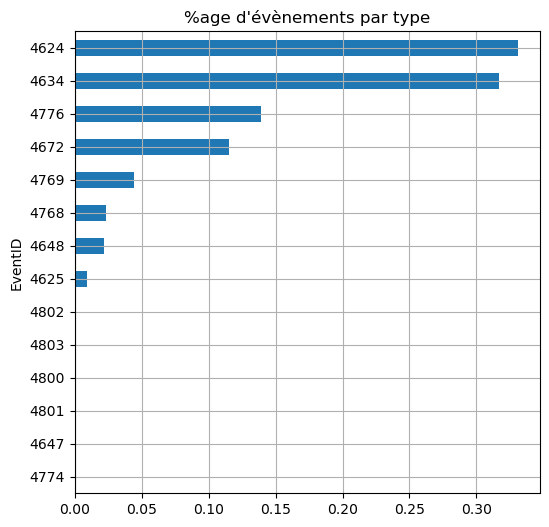

In [15]:
fig, ax = plt.subplots(figsize=(6,6))

eventid_counts = df['EventID'].value_counts() / df['EventID'].value_counts().sum()

ax = eventid_counts.plot(kind='barh')
ax.set_title("%age d'évènements par type")
ax.invert_yaxis()
ax.grid(True)
plt.show()

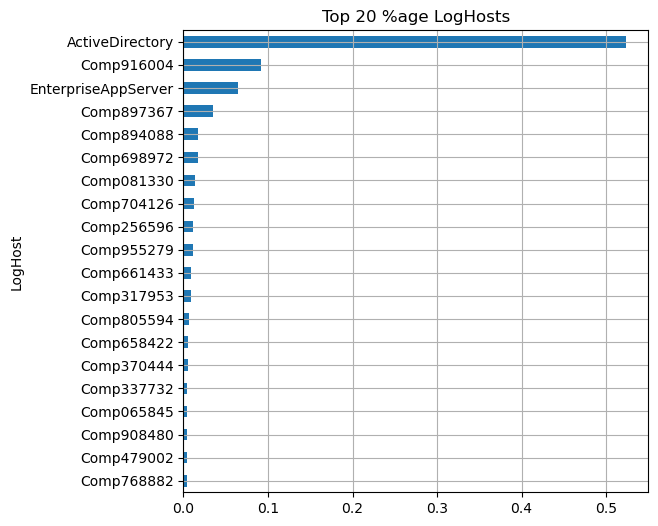

In [16]:
MAX_LOGHOSTS = 20

fig, ax = plt.subplots(figsize=(6,6))

loghost_counts = df['LogHost'].value_counts() / df['LogHost'].value_counts().sum()
ax = loghost_counts[:MAX_LOGHOSTS].plot(kind='barh')
ax.set_title(f"Top {MAX_LOGHOSTS} %age LogHosts")
ax.invert_yaxis()
ax.grid(True)
plt.show()

In [17]:
# MAX_LOGONIDS = 20

# fig, ax = plt.subplots(figsize=(6,6))

# logonids_counts = df['LogonID'].value_counts() / df['LogonID'].value_counts().sum()
# ax = logonids_counts[:MAX_LOGONIDS].plot(kind='barh')
# ax.set_title(f"Top {MAX_LOGONIDS} %age LogonIDs")
# ax.invert_yaxis()
# ax.grid(True)
# plt.show()

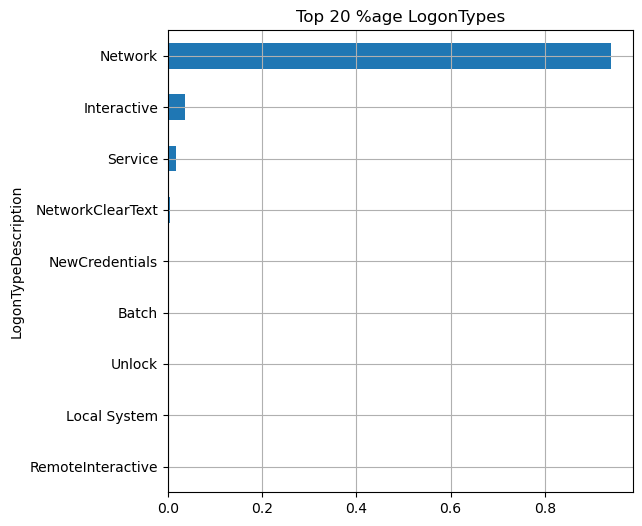

In [18]:
MAX_LOGONTYPES = 20

fig, ax = plt.subplots(figsize=(6,6))

logontype_counts = df['LogonTypeDescription'].value_counts() / df['LogonTypeDescription'].value_counts().sum()
ax = logontype_counts[:MAX_LOGONTYPES].plot(kind='barh')
ax.set_title(f"Top {MAX_LOGONTYPES} %age LogonTypes")
ax.invert_yaxis()
ax.grid(True)
plt.show()

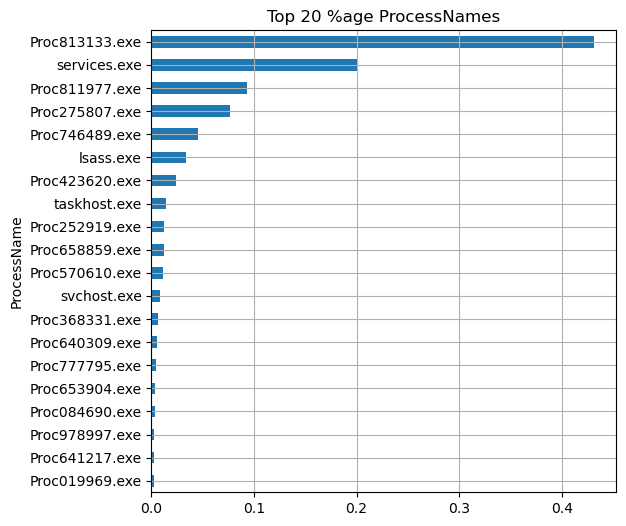

In [19]:
MAX_PROCESSNAMES = 20

fig, ax = plt.subplots(figsize=(6,6))

processname_counts = df['ProcessName'].value_counts() / df['ProcessName'].value_counts().sum()
ax = processname_counts[:MAX_PROCESSNAMES].plot(kind='barh')
ax.set_title(f"Top {MAX_PROCESSNAMES} %age ProcessNames")
ax.invert_yaxis()
ax.grid(True)
plt.show()

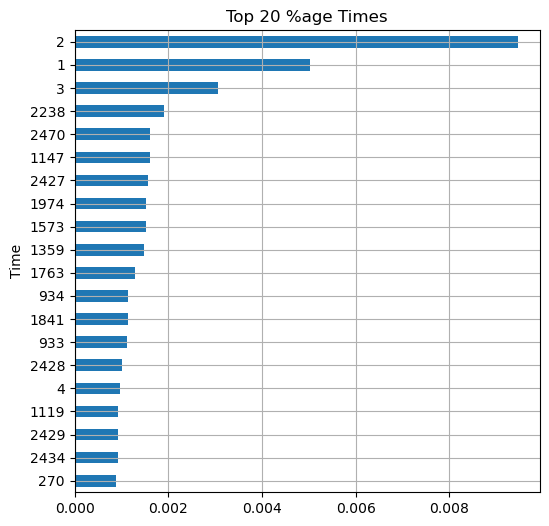

In [20]:
MAX_TIMES = 20

fig, ax = plt.subplots(figsize=(6,6))

times_counts = df['Time'].value_counts() / df['Time'].value_counts().sum()
ax = times_counts[:MAX_TIMES].plot(kind='barh')
ax.set_title(f"Top {MAX_TIMES} %age Times")
ax.invert_yaxis()
ax.grid(True)
plt.show()

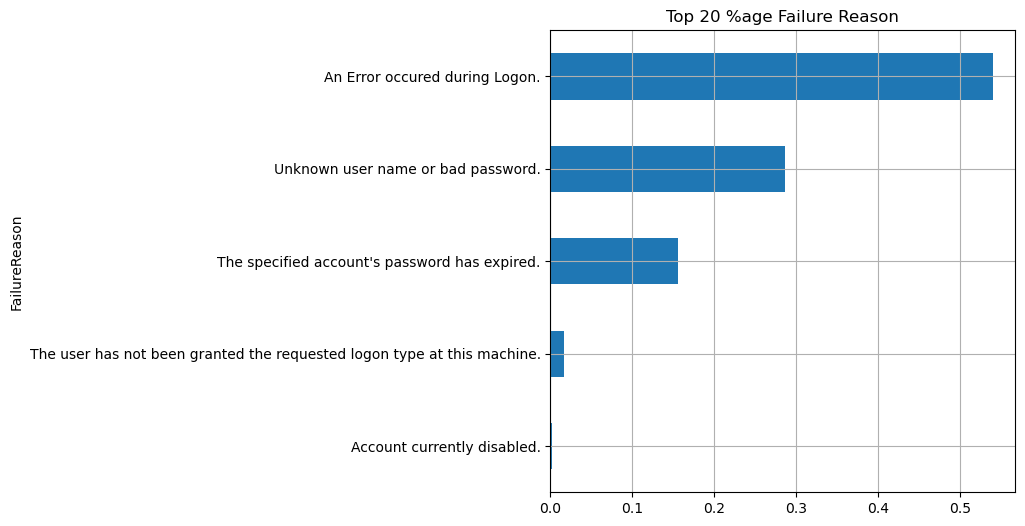

In [21]:
MAX_FAILURE_REASONS = 20

fig, ax = plt.subplots(figsize=(6,6))

fr_counts = df['FailureReason'].value_counts() / df['FailureReason'].value_counts().sum()
ax = fr_counts[:MAX_FAILURE_REASONS].plot(kind='barh')
ax.set_title(f"Top {MAX_FAILURE_REASONS} %age Failure Reason")
ax.invert_yaxis()
ax.grid(True)
plt.show()

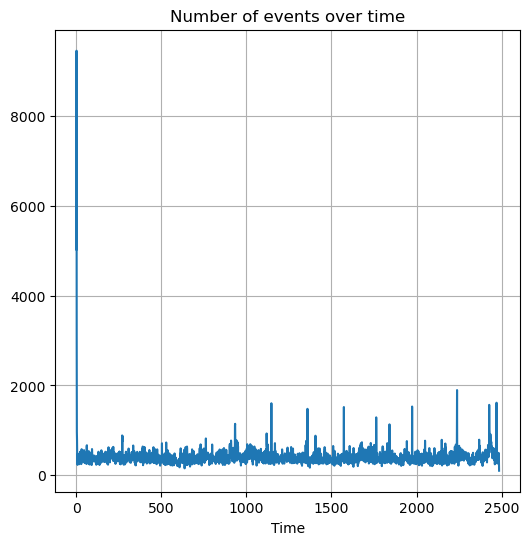

In [22]:
fig, ax = plt.subplots(figsize=(6,6))

ax = df['Time'].value_counts(sort=False).plot()
ax.set_title('Number of events over time')
ax.grid(True)

# Get a DataFrame from one record and transform it into categorical data

In [23]:
N = 1000000 #index of the file to process, number of samples

In [24]:
df = get_df_from_file(n_eda=N)

EDA sur wls_day-01_subset_1000000.json


In [25]:
# Nettoyage

# 1- Une simple PCA montre que les LogonIDs expliquent 99% de la variance : on les retire

df.drop(columns=['LogonID'], inplace=True)

In [26]:
df

,UserName,EventID,LogHost,DomainName,LogonTypeDescription,ProcessName,AuthenticationPackage,Time,LogonType,ProcessID,Source,Destination,SubjectUserName,SubjectLogonID,SubjectDomainName,Status,ServiceName,FailureReason
0,system,4624,Comp828729,nt authority,Service,services.exe,Negotiate,1,5.0,0x29c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,system,4672,Comp828729,nt authority,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,system,4672,Comp423597,nt authority,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,system,4624,Comp050550,nt authority,Service,services.exe,Negotiate,1,5.0,0x2ec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Comp939275$,4624,Comp661433,Domain001,Network,NaN,Kerberos,1,3.0,NaN,Comp939275,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,User897275,4768,ActiveDirectory,Domain001,NaN,NaN,NaN,2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0,NaN,NaN
999996,User897275,4768,ActiveDirectory,Domain001,NaN,NaN,NaN,2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0,NaN,NaN
999997,User897275,4768,ActiveDirectory,Domain001,NaN,NaN,NaN,2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0,NaN,NaN
999998,User897275,4769,ActiveDirectory,Domain001,NaN,NaN,NaN,2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0,Comp897367$,NaN


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   UserName               1000000 non-null  object 
 1   EventID                1000000 non-null  int64  
 2   LogHost                1000000 non-null  object 
 3   DomainName             1000000 non-null  object 
 4   LogonTypeDescription   656903 non-null   object 
 5   ProcessName            57833 non-null    object 
 6   AuthenticationPackage  479381 non-null   object 
 7   Time                   1000000 non-null  int64  
 8   LogonType              656903 non-null   float64
 9   ProcessID              57833 non-null    object 
 10  Source                 424924 non-null   object 
 11  Destination            22160 non-null    object 
 12  SubjectUserName        22517 non-null    object 
 13  SubjectLogonID         22523 non-null    object 
 14  SubjectDomainName  

In [28]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UserName,1000000,12309,Comp916004$,108928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EventID,1000000.0,NaN,NaN,NaN,4664.048422,57.619354,4624.0,4624.0,4634.0,4672.0,4803.0
LogHost,1000000,6062,ActiveDirectory,523660,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DomainName,1000000,22,Domain001,926699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogonTypeDescription,656903,9,Network,617082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProcessName,57833,36,Proc813133.exe,24953,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AuthenticationPackage,479381,5,Kerberos,243708,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,1000000.0,NaN,NaN,NaN,1236.259687,734.233544,1.0,610.0,1226.0,1867.0,2485.0
LogonType,656903.0,NaN,NaN,NaN,3.034465,0.534086,0.0,3.0,3.0,3.0,10.0
ProcessID,57833,1290,0x1f00,23472,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Traitement des données

In [29]:
def process_df_into_cat(df=df):
    """Process DataFrame from wls into a DataFrame with integer-based categorical values, 
    except time, that remains as is.

    Args:
        df (_type_, optional): Dataframe issued from a wls file. Defaults to df.
    """
    
    # create a unique identifier for the user
    df['UserNameAndDomainName'] = df['UserName'] + '_' + df['DomainName']
    
    # manages all columns except Time
    columns = list(df.columns)
    columns.remove('Time')
    for c in columns:
        c_new = c + '_code'
        df[c_new] = df[c].astype("category").cat.codes
        
    df.drop(columns=columns, inplace=True)
    return df

In [30]:
df = process_df_into_cat(df=df)

In [31]:
df

,Time,UserName_code,EventID_code,LogHost_code,DomainName_code,LogonTypeDescription_code,ProcessName_code,AuthenticationPackage_code,LogonType_code,ProcessID_code,Source_code,Destination_code,SubjectUserName_code,SubjectLogonID_code,SubjectDomainName_code,Status_code,ServiceName_code,FailureReason_code,UserNameAndDomainName_code
0,1,12308,0,4978,21,7,31,4,4,711,-1,-1,-1,-1,-1,-1,-1,-1,12340
1,1,12308,5,4978,21,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,12340
2,1,12308,5,2514,21,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,12340
3,1,12308,0,333,21,7,31,4,4,765,-1,-1,-1,-1,-1,-1,-1,-1,12340
4,1,6903,0,3925,13,3,-1,1,2,-1,7134,-1,-1,-1,-1,-1,-1,-1,6912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2485,11782,6,0,13,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,11813
999996,2485,11782,6,0,13,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,11813
999997,2485,11782,6,0,13,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,11813
999998,2485,11782,7,0,13,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,2853,-1,11813


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype
---  ------                      --------------    -----
 0   Time                        1000000 non-null  int64
 1   UserName_code               1000000 non-null  int16
 2   EventID_code                1000000 non-null  int8 
 3   LogHost_code                1000000 non-null  int16
 4   DomainName_code             1000000 non-null  int8 
 5   LogonTypeDescription_code   1000000 non-null  int8 
 6   ProcessName_code            1000000 non-null  int8 
 7   AuthenticationPackage_code  1000000 non-null  int8 
 8   LogonType_code              1000000 non-null  int8 
 9   ProcessID_code              1000000 non-null  int16
 10  Source_code                 1000000 non-null  int16
 11  Destination_code            1000000 non-null  int16
 12  SubjectUserName_code        1000000 non-null  int16
 13  SubjectLogonID_code         

In [33]:
df.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Time,1000000.0,1236.259687,734.233544,1.0,610.0,1226.0,1867.0,2485.0
UserName_code,1000000.0,5892.754640,4096.055521,0.0,1480.0,6736.0,8811.0,12308.0
EventID_code,1000000.0,3.003429,3.119944,0.0,0.0,2.0,5.0,13.0
LogHost_code,1000000.0,2020.211295,2459.708170,0.0,0.0,0.0,4841.0,6061.0
DomainName_code,1000000.0,13.413027,1.737828,0.0,13.0,13.0,13.0,21.0
LogonTypeDescription_code,1000000.0,1.631691,1.976718,-1.0,-1.0,3.0,3.0,8.0
ProcessName_code,1000000.0,0.306984,5.612732,-1.0,-1.0,-1.0,-1.0,35.0
AuthenticationPackage_code,1000000.0,0.316257,1.506340,-1.0,-1.0,-1.0,1.0,4.0
LogonType_code,1000000.0,0.988987,1.487562,-1.0,-1.0,2.0,2.0,8.0
ProcessID_code,1000000.0,35.770193,165.022776,-1.0,-1.0,-1.0,-1.0,1289.0


# PCA - baseline

In [34]:
from sklearn.decomposition import PCA

### 2D

In [35]:
pca2d = PCA(n_components=2)
pca2d.fit(df)

PCA(n_components=2)

In [36]:
pca2d.explained_variance_ratio_

array([0.6973972 , 0.16608953])

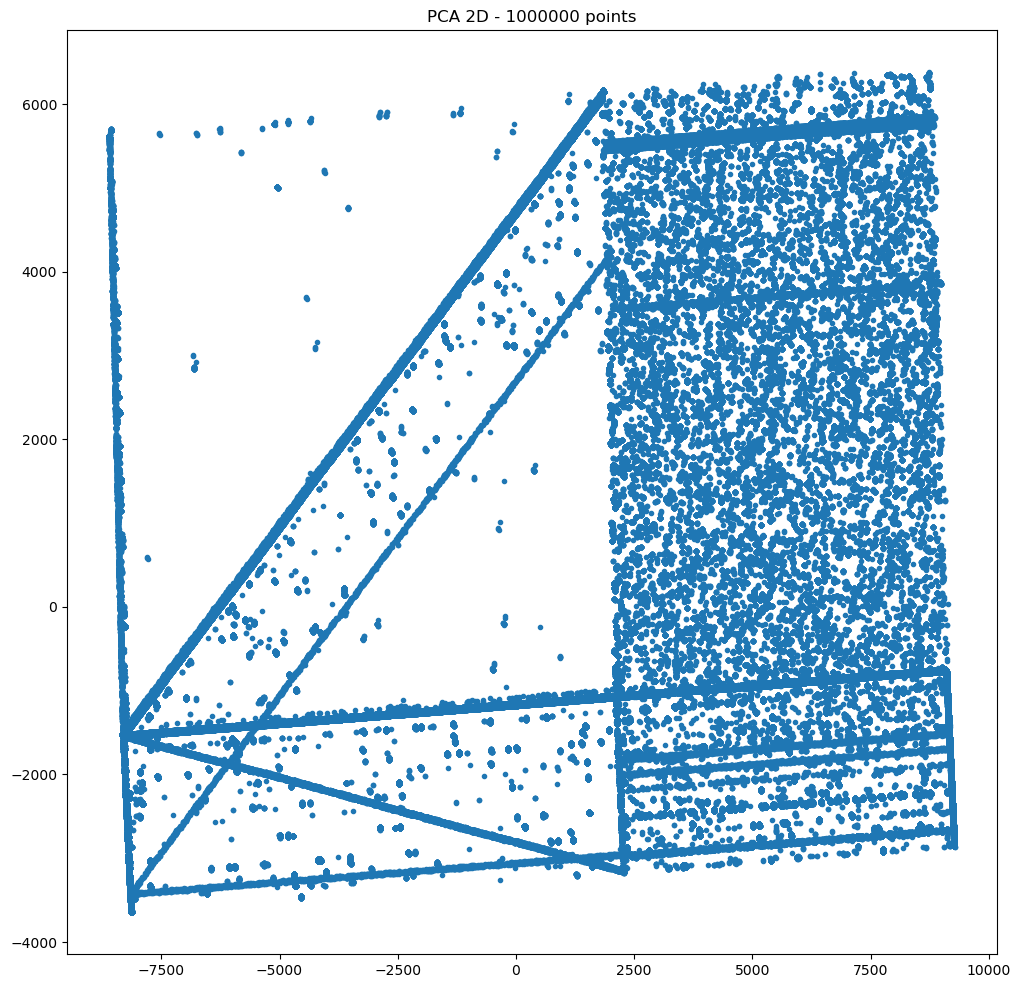

In [37]:
X_red2d = pca2d.transform(df)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()

ax.scatter(X_red2d[:,0], X_red2d[:,1], marker='.')
ax.set_title(f'PCA 2D - {N} points')
plt.show()

### 3D

In [38]:
pca = PCA(n_components=3)
pca.fit(df)

PCA(n_components=3)

In [39]:
pca.explained_variance_ratio_

array([0.6973972 , 0.16608953, 0.11949073])

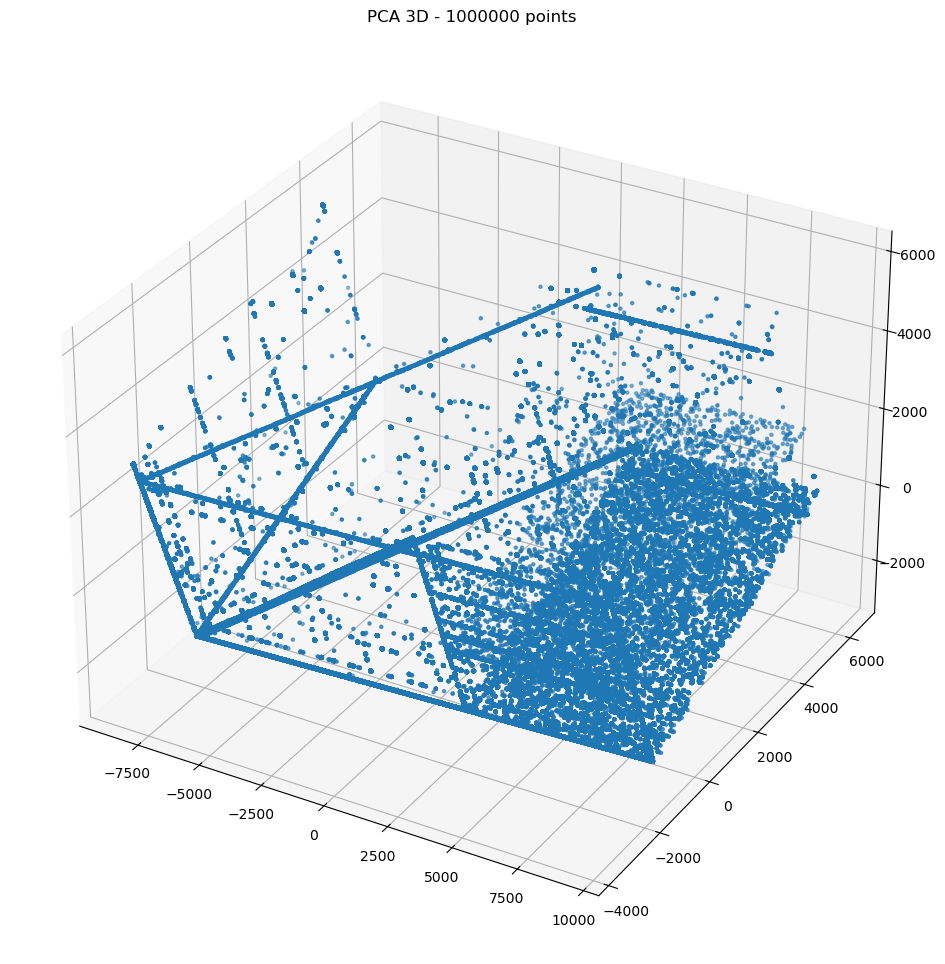

In [40]:
X_red = pca.transform(df)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], marker='.')
ax.set_title(f'PCA 3D - {N} points')
plt.show()

### Un peu d'explications

In [41]:
def get_df_expl(pca, df=df):
    """return a Dataframe with explained variance ratio and decomposition of eigenvectors in pca model

    Args:
        pca (_type_): pca model, already fit
        df (_type_, optional): original dataframe. Defaults to df.
    """
    
    # to loop over number of components
    n_components = range(pca.n_components_)
    
    # build a dictionnary of n eigenvectors, each value is the list of coordinates in data space
    dict_eigenvectors = {
    n : list(pca.components_[n,:]) for n in n_components
}

    # build full dictionnary to pass to DF constructor
    dict = {
    'Explained_Variance_Ratio' : list(pca.explained_variance_ratio_),
}

    columns = list(df.columns)

    for i, c in enumerate(columns):
        dict[c] = [ dict_eigenvectors[j][i] for j in n_components]
        
    # build and return dataframe
    df_expl = pd.DataFrame.from_dict(data=dict)
    
    return df_expl

In [42]:
df_expl = get_df_expl(pca, df)

In [43]:
df_expl.transpose()

,0,1,2
Explained_Variance_Ratio,0.697397,0.166090,0.119491
Time,-0.004591,0.011745,-0.014855
UserName_code,0.705592,0.031722,-0.009052
EventID_code,-0.000057,0.000006,-0.000265
LogHost_code,0.027780,-0.343764,0.937828
DomainName_code,-0.000011,-0.000079,0.000096
LogonTypeDescription_code,0.000012,-0.000024,0.000029
ProcessName_code,0.000241,-0.000058,0.000490
AuthenticationPackage_code,-0.000029,0.000255,0.000095
LogonType_code,0.000010,-0.000014,0.000037


### Generalization to n eigenvectors > 3

In [44]:
N_COMPONENTS = 5

In [45]:
pca = PCA(n_components=N_COMPONENTS)
pca.fit(df)

PCA(n_components=5)

In [46]:
pca.explained_variance_ratio_

array([0.6973972 , 0.16608953, 0.11949073, 0.01110945, 0.00507618])

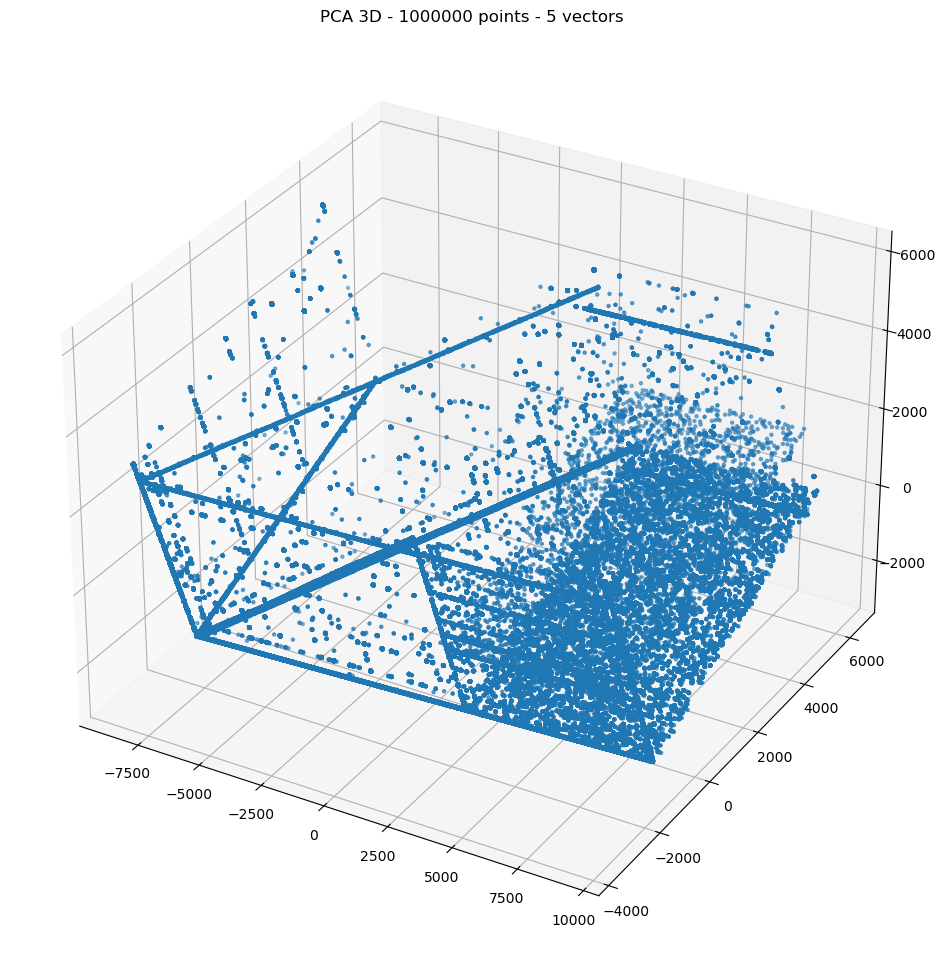

In [47]:
X_red = pca.transform(df)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_red[:,0], X_red[:,1], X_red[:,2], marker='.')
ax.set_title(f'PCA 3D - {N} points - {N_COMPONENTS} vectors')
plt.show()

In [48]:
df_expl = get_df_expl(pca, df)

df_expl.transpose()

,0,1,2,3,4
Explained_Variance_Ratio,0.697397,0.166090,0.119491,1.110945e-02,0.005076
Time,-0.004591,0.011745,-0.014855,9.992680e-01,-0.031145
UserName_code,0.705592,0.031722,-0.009052,2.383689e-03,-0.009007
EventID_code,-0.000057,0.000006,-0.000265,-5.972091e-05,0.001461
LogHost_code,0.027780,-0.343764,0.937828,1.908853e-02,0.031666
DomainName_code,-0.000011,-0.000079,0.000096,-2.903033e-04,0.000001
LogonTypeDescription_code,0.000012,-0.000024,0.000029,-6.198975e-05,-0.000985
ProcessName_code,0.000241,-0.000058,0.000490,-2.118819e-04,-0.000546
AuthenticationPackage_code,-0.000029,0.000255,0.000095,-1.011499e-04,-0.000630
LogonType_code,0.000010,-0.000014,0.000037,-1.139943e-05,-0.000742


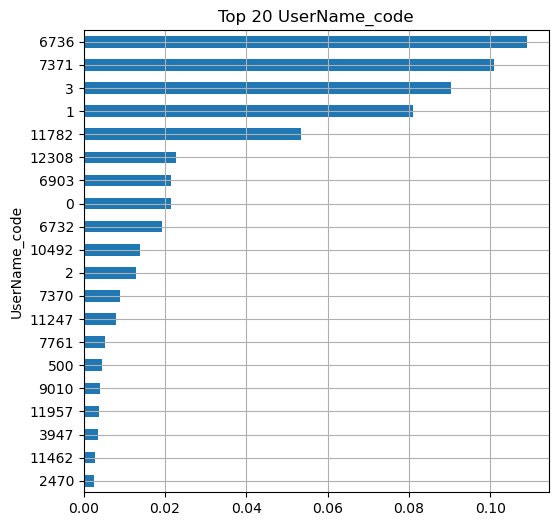

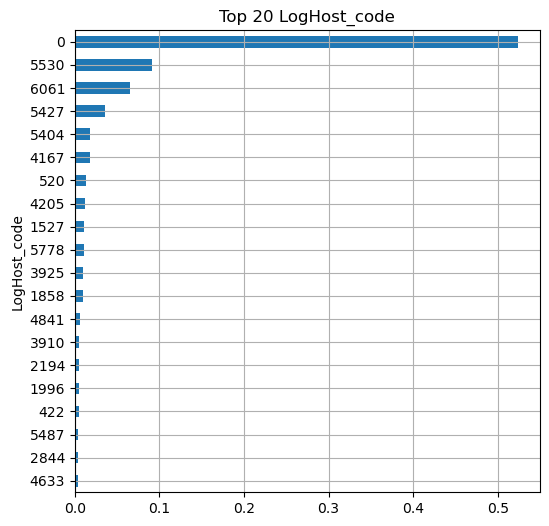

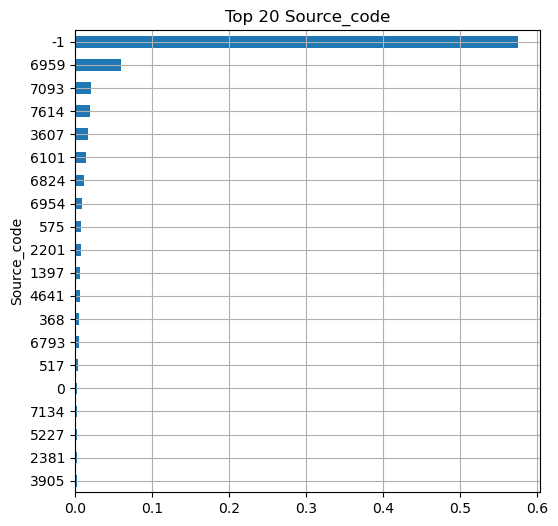

In [49]:
# regardons UserName_code, LogHost_code, Source_code

list_columns = ['UserName_code', 'LogHost_code', 'Source_code']
MAX_CAT = 20

for c in list_columns:
    fig, ax = plt.subplots(figsize=(6,6))

    counts = df[c].value_counts() / df[c].value_counts().sum()
    ax = counts[:MAX_CAT].plot(kind='barh')
    ax.set_title(f"Top {MAX_CAT} " + c)
    ax.invert_yaxis()
    ax.grid(True)
    plt.show()